### Basic imports

In [98]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

### Download the data

In [99]:

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_housing_data()


### Raw insights

In [100]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [101]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [102]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

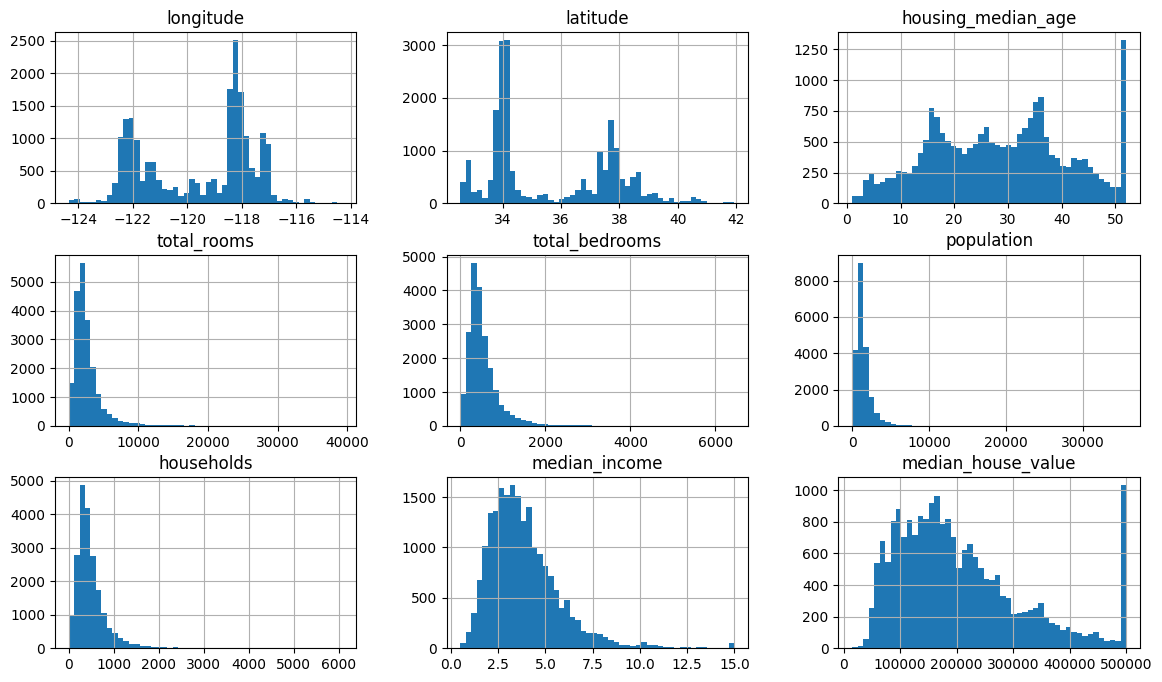

In [103]:
housing.hist(bins = 50, figsize=(14,8))

### Data split

Naive way, not the best approach as depends on random seed; works poor if the dataset is changed

In [104]:
def test_split(data, ratio):
    shuffled = np.random.permutation(len(data))
    test_size = int(len(data) * ratio)
    train_ind = shuffled[test_size:]
    test_ind = shuffled[:test_size]
    return data.iloc[train_ind], data.iloc[test_ind]

In [105]:
train_set, test_set = test_split(housing, 0.15)
test_set.count()

longitude             3096
latitude              3096
housing_median_age    3096
total_rooms           3096
total_bedrooms        3053
population            3096
households            3096
median_income         3096
median_house_value    3096
ocean_proximity       3096
dtype: int64

More sophisticated way, using hashes

In [106]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_id = housing.reset_index()
train_set, test_set = split_data_with_hash(housing_id, 0.15, "index")
train_set.describe()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17367.000000,17544.00000,17544.000000,17544.000000,17544.000000
mean,10319.877850,-119.562247,35.624053,28.630586,2635.973438,538.241896,1423.92402,499.866336,3.867683,206629.629275
std,5958.287449,2.006365,2.135743,12.608656,2192.980901,425.269165,1138.30044,385.441967,1.896851,115370.378438
min,0.000000,-124.350000,32.540000,1.000000,2.000000,1.000000,5.00000,1.000000,0.499900,14999.000000
25%,5161.500000,-121.800000,33.930000,18.000000,1445.000000,295.000000,784.00000,279.000000,2.562500,119600.000000
50%,10318.500000,-118.490000,34.250000,29.000000,2124.000000,433.000000,1164.00000,408.000000,3.533300,179350.000000
75%,15482.250000,-118.000000,37.710000,37.000000,3138.250000,646.000000,1726.00000,605.000000,4.742200,264400.000000
max,20639.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.00000,6082.000000,15.000100,500001.000000


Although, there are ready solutions, for example in scikit-learn library (same naive way BTW)

In [107]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Methods mentioned above are based off random. The issue is that it may cause bias. For example, when making a survey, you want to have a more representative sample.

Suppose that certain expert mentioned that the median income is an essential parameter. Let's introduce new categories for this parameter.

In [108]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],  labels=[1, 2, 3, 4, 5])

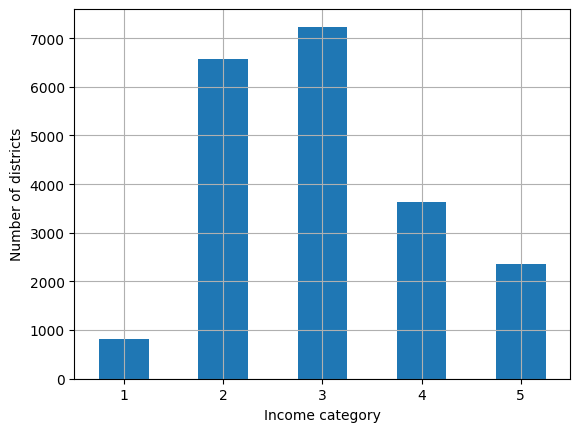

In [109]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

The stratified split can be applied to the data set in order to obtain "better" splits

In [110]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [111]:
strat_train_set, strat_test_set = strat_splits[0]
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN,2
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND,2
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN,4
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY,4


The code below works as well

In [112]:
strat_train_set, strat_test_set = train_test_split(
 housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [113]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

As the column with median categories won't be used again, it can be dropped

In [114]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Data visualization and analysis

In [115]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

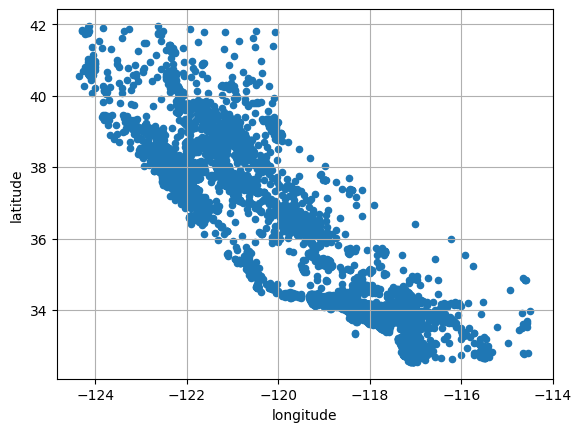

In [116]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True)

It's hard to get anything from the plot above, so one should try to reduce the transparency

<Axes: xlabel='longitude', ylabel='latitude'>

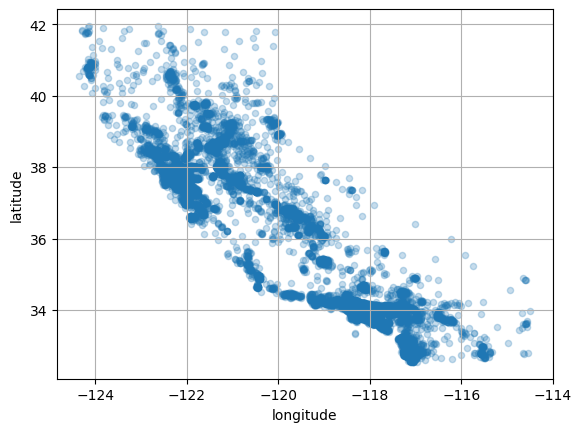

In [117]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.25)

<Axes: xlabel='longitude', ylabel='latitude'>

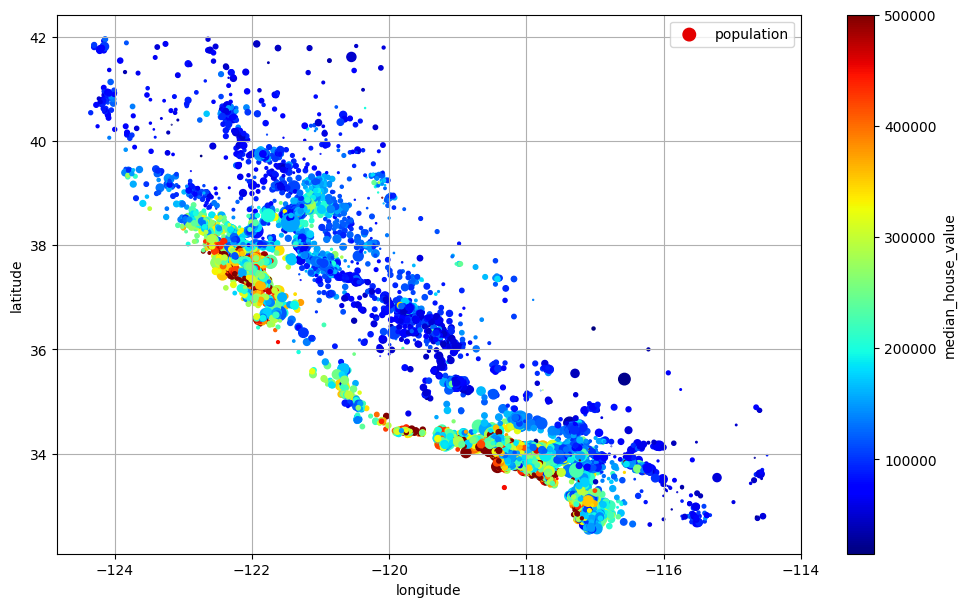

In [118]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, s = housing["population"] / 100, label = "population",
             c = "median_house_value", cmap = "jet", colorbar = True, legend = True, figsize = (12, 7))

The radius of each circle represent a distinct population, and the color represents the price.

#### Correlations

In [119]:
corr_mat = housing.corr()
corr_mat

ValueError: could not convert string to float: 'NEAR BAY'

Longitude - latitude, Total rooms - TOtal bedrooms, Total rooms - population, Total rooms - households, ...... correlate good enough (abs(corr) is close to 1)

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

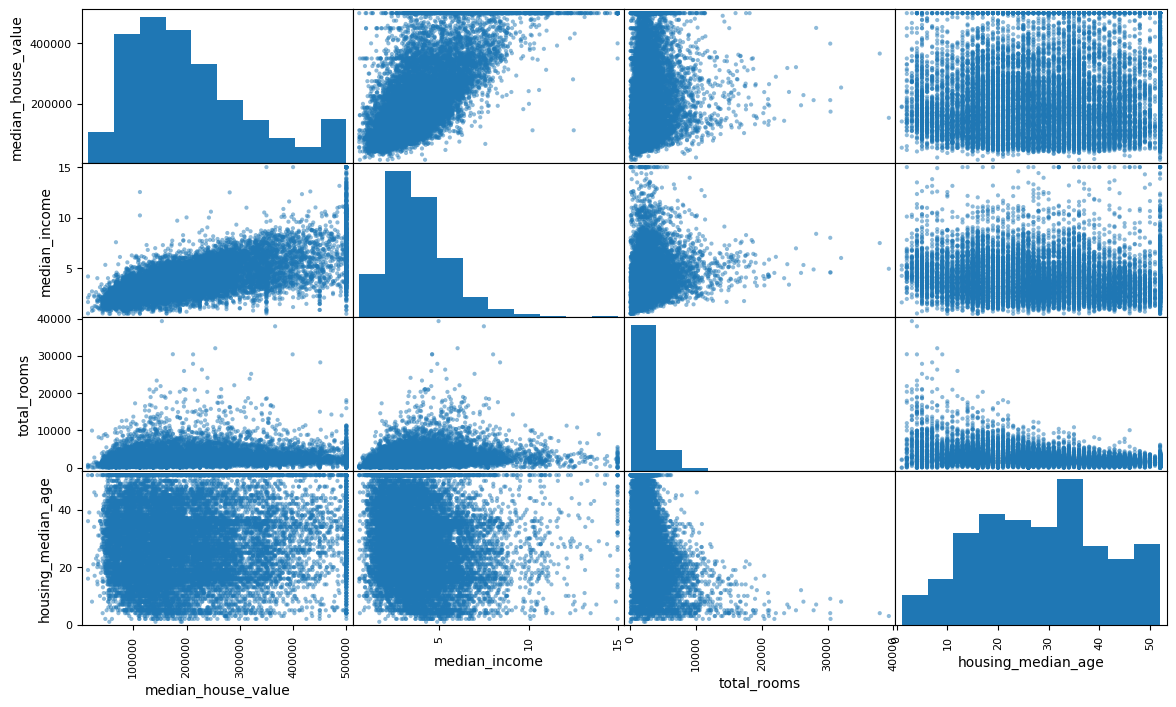

In [120]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(14,8 ))

In [121]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [122]:
corr_mat = housing.corr()
corr_mat["median_house_value"].sort_values()

ValueError: could not convert string to float: 'NEAR BAY'

### Preparing data for an algorithm

In [123]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

From the initial insights, it can be seen that some values are missing, so one must fix it

In [124]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

C:\Users\basys\AppData\Local\Temp\ipykernel_8084\2694038511.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


There is a handy class in sklearn which is used to handle missing data

In [125]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [127]:
housing_n = housing.select_dtypes(include=[np.number])
imputer.fit(housing_n)

SimpleImputer(strategy='median')

In [128]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [129]:
housing_n.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now using the imputer one can transform the training set by replacing missing values with the learned medians

In [130]:
X = imputer.transform(housing_n)

#### Categorical attributes

In [131]:
housing_cat = housing[["ocean_proximity"]]

In [133]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [136]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [137]:
cat_encoder.feature_names_in_


array(['ocean_proximity'], dtype=object)

In [138]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

#### Feature scaling

In [140]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_minmax = min_max_scaler.fit_transform(housing_n)
housing_minmax

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]], shape=(16512, 8))

In [142]:
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
housing_standart = standart_scaler.fit_transform(housing_n)
housing_standart

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]], shape=(16512, 8))

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
age_similarity = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

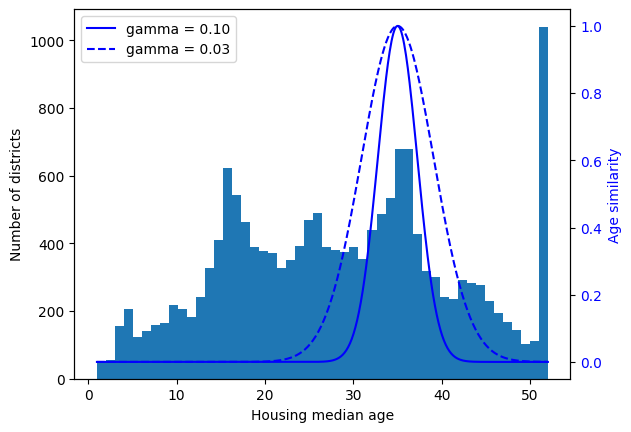

In [147]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")

One must inverse transform when the predictions upon transformed data are obtained

In [148]:
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
scaled_labels = scaler.fit_transform(housing_labels.to_frame())
lm = LinearRegression()
lm.fit(housing[["median_income"]], scaled_labels)
data = housing[["median_income"]].iloc[:5]

predictions = scaler.inverse_transform(lm.predict(data))
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

OR

In [149]:
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(), transformer=scaler)
model.fit(housing[["median_income"]], housing_labels)
predictions2 = model.predict(data)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

### Custom transformers

In [151]:
from sklearn.preprocessing import FunctionTransformer
log_transform = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transform.transform(housing[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [153]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class OwnStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mean = True):
        self.mean = mean

    def fit(self, X, y = None):
        X = check_array(X)
        self.mean_ = X.mean(axis = 0)
        self.scale_ = X.std(axis = 0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.mean:
            X = X - self.mean
        return X / self.scale_


Custom transformers may use other estimators in its implementation.

In [187]:
from sklearn.cluster import KMeans

class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 20, gamma = 0.2, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y = None, weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
        self.kmeans_.fit(X, y, weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [157]:
kmeanst = KMeansTransformer(random_state=42)
sim = kmeanst.fit_transform(housing[["latitude", "longitude"]], weight = housing_labels)

C:\Users\basys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\basys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [158]:
sim[:3].round(2)

array([[0.  , 0.94, 0.02, 0.  , 0.32, 0.15, 0.62, 0.88, 0.  , 0.76, 0.11,
        0.  , 1.  , 0.8 , 0.1 , 0.  , 0.  , 0.1 , 0.58, 0.  ],
       [0.92, 0.01, 0.8 , 0.5 , 0.  , 0.23, 0.  , 0.  , 1.  , 0.02, 0.34,
        0.82, 0.  , 0.01, 0.  , 0.62, 0.31, 0.1 , 0.03, 0.98],
       [0.  , 0.83, 0.01, 0.  , 0.54, 0.17, 0.86, 0.88, 0.  , 0.61, 0.07,
        0.  , 0.92, 0.91, 0.14, 0.  , 0.  , 0.15, 0.67, 0.  ]])

### Pipelines

In [159]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline(
    ("impute", SimpleImputer(strategy="mean"),
     ("standartize", StandardScaler())
    )
)

In [160]:
import sklearn
sklearn.set_config(display="diagram")

In [166]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [167]:
housing_prepared = num_pipeline.fit_transform(housing_n)
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]], shape=(16512, 8))

In [170]:
df_housing_num_prepared = pd.DataFrame(
    housing_prepared, columns=num_pipeline.get_feature_names_out()
)
df_housing_num_prepared.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
1,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
2,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
3,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
4,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


#### All columns pipeline

In [181]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
 "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


In [182]:
housing_prepared = preprocessing.fit_transform(housing)

In [219]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = KMeansTransformer(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
    StandardScaler())
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
    "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
 ],
 remainder=default_num_pipeline)

In [220]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [221]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Training the model

#### Linear Regression

Good old LM...

In [222]:
from sklearn.linear_model import LinearRegression
lm = make_pipeline(preprocessing, LinearRegression())
lm.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  KMeansTransformer(gamma=1.0,
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000214D9485310>)])),
                ('linearregression', LinearRegression())])

In [224]:
housing_predictions = lm.predict(housing)
for a, b in zip(housing_predictions[:5].round(-2), housing_labels.iloc[:5].values):
    print(a, b)

246000.0 458300.0
372700.0 483800.0
135700.0 101700.0
91400.0 96100.0
330900.0 361800.0


In [227]:
from sklearn.metrics import mean_squared_error
lm_rmse = mean_squared_error(housing_labels, housing_predictions)
lm_rmse

4757259431.847188

#### Decision Trees

Consider another, more complex model, for the task.

In [228]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = make_pipeline(preprocessing, DecisionTreeRegressor())
dec_tree.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  KMeansTransformer(gamma=1.0,
                                                                    n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000214D9485310>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [230]:
predictions = dec_tree.predict(housing)
tree_rmse = mean_squared_error(housing_labels, predictions)
tree_rmse

0.0

#### Cross-validation

In [231]:
from sklearn.model_selection import cross_val_score
tree_rmses = cross_val_score(dec_tree, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
tree_rmses

array([-65194.60570011, -65720.67889043, -65972.82828373, -66732.55367573,
       -65754.04340344, -65505.3748363 , -65675.73386129, -68083.12623413,
       -67898.26405866, -68218.74786   ])

In [234]:
pd.Series(tree_rmses).describe()

count       10.000000
mean    -66475.595680
std       1168.004070
min     -68218.747860
25%     -67606.836463
50%     -65863.435844
75%     -65686.970119
max     -65194.605700
dtype: float64

Still poor predictions on "real" data, whereas the training error is 0. OVERFIT!!!!

In [232]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor())
forest_rmses = cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [233]:
pd.Series(forest_rmses).describe()

count       10.000000
mean    -47028.475725
std       1005.504970
min     -49025.432565
25%     -47509.601384
50%     -47108.626672
75%     -46441.855421
max     -45480.007837
dtype: float64

### Fine-tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
    'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
    'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
    scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.head()

#### Randomized search

In [236]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20)}
rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000214D93D9990>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000214D949EB10>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
    final_model["preprocessing"].get_feature_names_out()),
    reverse=True)

### Evaluating

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions)
print(final_rmse)

## Exercises

### 1. SVM

In [243]:
from sklearn.svm import SVR

svm = make_pipeline(preprocessing, SVR(kernel="rbf"))
svm_rmses = cross_val_score(svm, housing[:5000], housing_labels[:5000], scoring="neg_root_mean_squared_error", cv=6)

In [245]:
svm_rmses

array([-121656.33944546, -119486.73476596, -126298.13653535,
       -118363.6273132 , -116542.92205241, -115813.25368862])

In [249]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svm", SVR()),
])
param_grid = [
    {
        # 'preprocessing__geo__n_clusters': [5, 8, 10],
        'svm__kernel': ['linear', 'rbf'],
        # 'svm__C': [0.1, 1, 10],
        # 'svm__epsilon': [0.1, 0.2, 0.5],
    }
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         ['latitude',
                                                                          'longitude']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000214D9485310>)])),
                                       ('svm', SVR())]),
             param_grid=[{'svm__kernel': ['linear', 'rbf']}],
             scoring='neg_root_mean_squared_error')

In [263]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

np.float64(113275.78629956034)

In [264]:
grid_search.best_params_

{'svm__kernel': 'linear'}

#### 2. Randomized

In [261]:
rnd_search = RandomizedSearchCV(
    full_pipeline, n_iter=10, cv=3, param_distributions=param_grid,
    scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

C:\Users\basys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x00000214D9485310>)])),
                                             ('svm', SVR())]),
                   param_distributions=[{'svm__kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [266]:
final_model = -rnd_search.best_score_
final_model

np.float64(113275.78629956032)

#### 3. SelectFromModel 

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = make_pipeline(
    ('preproccessing', preprocessing),
    ('selector,', SelectFromModel(RandomForestRegressor())),
    ('svr', SVR())
)

#### 4. KNN Transformer

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

class KNNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors = 3, gamma = 1.0):
        self.n_neighbors = n_neighbors
        self.gamma = gamma
    
    def fit(self, X, y = None):
        self.knn = KNeighborsRegressor(n_neighbors = self.n_neighbors)
        self.knn.fit(X, y)
        return self
    
    def transform(self, X):
        dist, _ = self.knn.kneighbors(X)
        return rbf_kernel(dist, gamma = self.gamma)

#### 5. skip as i cannot run code rn

#### 6. Standard Scaler clone

In [ ]:
class OwnStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mean = True):
        self.mean = mean

    def fit(self, X, y = None):
        X = check_array(X)
        self.mean_ = X.mean(axis = 0)
        self.scale_ = X.std(axis = 0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.mean:
            X = X - self.mean
        return X / self.scale_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return X * self.scale_ + (self.mean_ if self.mean else 0)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            assert len(input_features) == self.n_features_in_
            assert not hasattr(self, "feature_names_in_") or np.all(self.feature_names_in_ == input_features)
            return input_features